# DAiSEE Model Analysis
- The purpose of this notebook is to run predictions with the pre-trained model and generate gender-based prediction analytics for bias quantification.

# Setup Requirements:
- A folder with the generated samples should be located in a realative path: './dataset/'
- Model should be located in a relative path: './Models/
- A folder with some out-of-dataset images should be located in a relative path: './test_image'

In [1]:
import cv2
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

import os

from tqdm import tqdm
from matplotlib import image

import pickle

import pandas as pd

# Load and describe the model

In [2]:
print("Loading the DaiSEE model...")
model_dir = "Models/"
#model_name = 'Xception_on_DAiSEE.h5'
model_name = 'Xception_on_DAiSEE_finetune_fc.h5'
ER_model = load_model(f"{str(model_dir)}/{str(model_name)}")

Loading the DaiSEE model...


In [3]:
ER_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

In [4]:
#ER_model.predict(, 299, 299, 3)
ER_model.predict(np.zeros(shape=(1, 299, 299, 3)))

[array([[ 0.11875295,  0.3779491 , -0.2794306 , -0.5486835 ]],
       dtype=float32),
 array([[-1.3864887 , -0.86402214,  0.1468235 ,  0.10713997]],
       dtype=float32),
 array([[ 0.33809486,  0.13875915, -0.32996583, -1.7506933 ]],
       dtype=float32),
 array([[ 0.06940885, -0.1062819 , -0.8146593 , -1.0521727 ]],
       dtype=float32)]

In [5]:
ER_model.output

[<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'y1')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'y2')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'y3')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'y4')>]

# Define functions for finding faces

In [6]:
def get_faces(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(gray,
                                         scaleFactor=1.3,
                                         minNeighbors=3,
                                         minSize=(30, 30))
    return faces

# testing whole sample

In [7]:
sample = './test_image/photo.jpg'
sample_image = cv2.imread(sample)

In [8]:
sample = './test_image/photo.jpg'
sample = './test_Image/sandwich.png'
sample_image = cv2.imread(sample)    
class_names = ['Boredom', 'Engagement', 'Confusion', 'Frustration']
img_width = 299
img_height = 299
roi_image = tf.keras.applications.xception.preprocess_input(sample_image)
    
roi_image = tf.image.resize(images=roi_image,
                            size=[img_width, img_height],
                            method=tf.image.ResizeMethod.BILINEAR)
roi_image = tf.reshape(roi_image, [1, img_width, img_height, 3]) #Reshaped it to (1,299,299,3)
result = ER_model.predict(roi_image)

In [9]:
result

[array([[ 0.905078 ,  0.3685838, -0.4386261, -1.7148715]], dtype=float32),
 array([[-2.911052  , -1.2696586 ,  0.37679374,  0.70323706]],
       dtype=float32),
 array([[ 0.38908923, -0.3620838 , -1.5549212 , -1.9940208 ]],
       dtype=float32),
 array([[ 0.24219827, -0.58111227, -1.1151416 , -2.1389942 ]],
       dtype=float32)]

In [10]:
np.argmax(result[1],axis=1)

array([3], dtype=int64)

# Testing cropped sample vs full frame sample

In [11]:
sample = './test_image/photo.jpg'
face_set = []

datum_img = cv2.imread(sample) 
datum_img = cv2.cvtColor(datum_img, cv2.COLOR_BGR2RGB)
faces = get_faces(datum_img)
for (x,y,w,h) in faces:
    ROI = datum_img[y:y+h, x:x+w]
    face_set.append((ROI, datum_img))

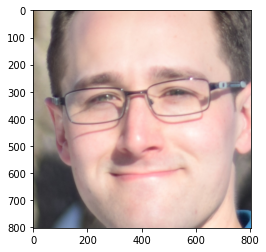

In [12]:
plt.imshow(face_set[0][0])

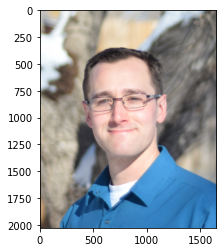

In [13]:
plt.imshow(face_set[0][1])

In [14]:
roi_image = tf.keras.applications.xception.preprocess_input(face_set[0][0])
    
roi_image = tf.image.resize(images=roi_image,
                            size=[img_width, img_height],
                            method=tf.image.ResizeMethod.BILINEAR)
roi_image = tf.reshape(roi_image, [1, img_width, img_height, 3]) #Reshaped it to (1,299,299,3)
result = ER_model.predict(roi_image)
result

[array([[ 0.49354792,  0.48499987,  0.23223245, -1.1370686 ]],
       dtype=float32),
 array([[-2.8212984 , -0.89220077,  0.9673065 ,  0.6161226 ]],
       dtype=float32),
 array([[ 0.7256668 , -0.04602811, -1.1157286 , -2.8234532 ]],
       dtype=float32),
 array([[-0.48412633, -0.5324375 , -0.79238003, -1.8717617 ]],
       dtype=float32)]

In [15]:
np.argmax(result[1],axis=1)

array([2], dtype=int64)

In [16]:
roi_image = tf.keras.applications.xception.preprocess_input(face_set[0][1])
    
roi_image = tf.image.resize(images=roi_image,
                            size=[img_width, img_height],
                            method=tf.image.ResizeMethod.BILINEAR)
roi_image = tf.reshape(roi_image, [1, img_width, img_height, 3]) #Reshaped it to (1,299,299,3)
result = ER_model.predict(roi_image)
result

[array([[ 0.22731718,  0.36836693,  0.3336102 , -1.9060788 ]],
       dtype=float32),
 array([[-3.6483254 , -1.1214774 ,  0.7965554 ,  0.36537027]],
       dtype=float32),
 array([[ 0.8121222 , -0.42142883, -1.0359799 , -2.761542  ]],
       dtype=float32),
 array([[-0.6855735 , -0.77247924, -1.0635126 , -2.8650286 ]],
       dtype=float32)]

In [17]:
np.argmax(result[1],axis=1)

array([2], dtype=int64)

# Preparation methods

In [158]:
def prepare_sample(sample, face_only=False):
    
    #raise NotImplementedError
    
    if face_only:
        try:
            #datum_img = cv2.imread(sample) 
            datum_img = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
            faces = get_faces(datum_img)
            face_set = []
            for (x,y,w,h) in faces:
                ROI = datum_img[y:y+h, x:x+w]
                face_set.append(ROI)
            sample = face_set[0]
        except IndexError:
            print('could not find a face for this sample')
    
    preprocessed = tf.keras.applications.xception.preprocess_input(sample)
    
    resized = tf.image.resize(images=preprocessed,
                                size=[img_width, img_height],
                                method=tf.image.ResizeMethod.BILINEAR)
    
    reshaped = tf.reshape(resized, [1, img_width, img_height, 3]) #Reshaped it to (1,299,299,3)
    
    return reshaped
   

In [105]:
os.listdir('./test_image/')

['photo.jpg', 'sandwich.png', 'source.txt']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


could not find a face for this sample


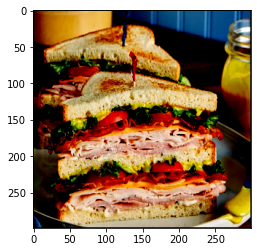

In [160]:
#sample = './test_image/photo.jpg'
sample = './test_image/sandwich.png'
face_set = []

datum_img = cv2.imread(sample) 

datum_img = cv2.cvtColor(datum_img, cv2.COLOR_BGR2RGB)

prepared = prepare_sample(datum_img, face_only=True)
plt.imshow(prepared[0])

In [162]:
sandwich_engagement = ER_model.predict(prepared)
np.argmax(sandwich_engagement[1],axis=1)

array([3], dtype=int64)

In [165]:
#The sandwich appears to be fully engaged!

# Look over the entire validation dataset

In [21]:
validation_dataset_location = './dataset/Validation'

In [25]:
labels = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'Labels', 'AllLabels.csv'))
females = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'GenderClips', 'Females'), header=None)
males = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'GenderClips', 'Males'), header=None)

females_list = [x[0] for x in females.values.tolist()]
males_list = [x[0] for x in males.values.tolist()]

In [26]:
females_list

['1110031003.avi',
 '1110031007.avi',
 '1110031010.avi',
 '1110031011.avi',
 '1110031012.avi',
 '1110031014.avi',
 '1110031019.avi',
 '1110031020.avi',
 '1110031021.avi',
 '1110031025.avi',
 '1110031027.avi',
 '1110031031.avi',
 '1110031033.avi',
 '1110031037.avi',
 '1110031038.avi',
 '1110031039.avi',
 '1110031040.avi',
 '1110031042.avi',
 '1110031048.avi',
 '1110031049.avi',
 '1110031050.avi',
 '1110031056.avi',
 '1110031061.avi',
 '1110031062.avi',
 '1110031063.avi',
 '1110031064.avi',
 '1110031065.avi',
 '1110032002.avi',
 '1110032004.avi',
 '1110032006.avi',
 '1110032008.avi',
 '1110032010.avi',
 '1110032014.avi',
 '1110032015.avi',
 '1110032018.avi',
 '1110032019.avi',
 '1110032020.avi',
 '1110032021.avi',
 '1110032022.avi',
 '1110032023.avi',
 '1110032024.avi',
 '1110032025.avi',
 '1110032027.avi',
 '1110032029.avi',
 '1110032031.avi',
 '1110032032.avi',
 '1110032033.avi',
 '1110032034.avi',
 '1110032036.avi',
 '1110032037.avi',
 '1110032042.avi',
 '1110032043.avi',
 '1110032045

In [31]:
# Add gender feature columns
labels['male'] = labels.apply(lambda x: x['ClipID'] in males_list, axis=1)
labels['female'] = labels.apply(lambda x: x['ClipID'] in females_list, axis=1)

In [32]:
labels

,ClipID,Boredom,Engagement,Confusion,Frustration,male,female
0,1100011002.avi,0,2,0,0,True,False
1,1100011003.avi,0,2,0,0,True,False
2,1100011004.avi,0,3,0,0,True,False
3,1100011005.avi,0,3,0,0,True,False
4,1100011006.avi,0,3,0,0,True,False
...,...,...,...,...,...,...,...
8920,9877360164.avi,1,3,0,0,False,True
8921,9877360165.avi,0,3,0,0,False,True
8922,9877360166.avi,1,3,0,2,False,True
8923,9877360168.avi,1,3,1,1,False,True


In [33]:
# we want to make sure that there is a binary constraint
assert labels.loc[labels['male']!=labels['female']].shape == labels.shape

In [34]:
# Create a single column for gender
labels['gender'] = labels.apply(lambda x: 1 if x['ClipID'] in males_list else 0, axis=1)

In [35]:
labels.columns

Index(['ClipID', 'Boredom', 'Engagement', 'Confusion', 'Frustration ', 'male',
       'female', 'gender'],
      dtype='object')

In [36]:
labels.drop(['male', 'female'], axis=1, inplace=True)

In [37]:
# We're only concerned with engagement
labels.drop(['Boredom', 'Confusion', 'Frustration '], axis=1, inplace=True)

array([[<AxesSubplot:title={'center':'Engagement'}>,
        <AxesSubplot:title={'center':'gender'}>]], dtype=object)

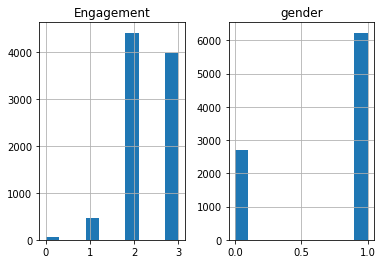

In [38]:
# Now we can view some basic statistics on the dataset
labels.hist()

<AxesSubplot:>

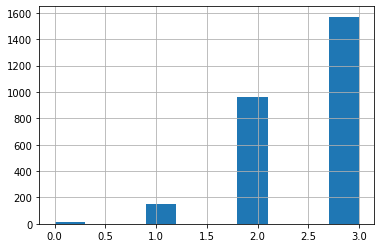

In [122]:
# Female Sample
labels[labels['gender']==0]['Engagement'].hist()

<AxesSubplot:>

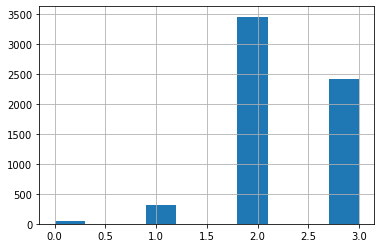

In [121]:
# Male Samples
labels[labels['gender']==1]['Engagement'].hist()

In [41]:
labels['ID'] = labels['ClipID'].str[:-4]

In [42]:
labels['ID'] = pd.to_numeric(labels['ID'])

In [43]:
labels[labels['ID']==int(1100011006)]['gender'].values[0]

1

# Load the samples
[Can jump to load pickled data](#load-pickled-data)

In [150]:
assert False, 'This step can be skipped, it takes about 30min. Can proceed to data loading'

AssertionError: This step can be skipped, it takes about 30min. Can proceed to data loading

In [45]:
# TODO: I think this is no longer needed
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [46]:
model = ER_model

In [50]:
labels[labels['ID']==int(1100011002)]['Engagement'].values[0]

2

In [51]:
labels[labels['ID']==int(1100011002)].values.tolist()[0][1:-1][1]

1

In [ ]:
dataset = os.path.join(os.getcwd(), 'dataset', 'Validation')

# Results should be a list in the form of:
# (y_pred, y_actual, gender)
results = []

img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input

#just look at train set for now
for filename in tqdm(os.listdir(dataset)):

    img_path = os.path.join(dataset, filename)

    # Prepare image
    img = image.imread(img_path)
    #img_array = preprocess_input(get_img_array(img_path, size=img_size))
    
    img_array = prepare_sample(img, face_only=True)

    # Predict
    preds = model.predict(img_array)
    sample_ID = filename[:filename.index('-')]
    
    y_actual = labels[labels['ID']==int(sample_ID)]['Engagement'].values[0]
    gender = labels[labels['ID']==int(sample_ID)]['gender'].values[0]

    results.append((np.argmax(preds[1]), y_actual, gender))

In [149]:
# Check for any issues with results
for result in results:
    assert not result[2] == None, 'Error in prediciton'

In [116]:
result_df = pd.DataFrame(results, columns=['y_pred', 'y_true', 'gender'])

In [117]:
# pickle the dataframe
result_df.to_pickle('results-faces.pkl')

# Notes:
- 1151 samples could not locate a face with the cv2 Haar cascade face detector

<a class="anchor" name="load-pickled-data"></a>
# Load pickled data

In [2]:
# load the pickled data
results_faces = pd.read_pickle('results-faces.pkl')
results_full_frame = pd.read_pickle('results-full-frame.pkl')

# Metrics

In [3]:
#!pip install fairlearn

In [5]:
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame

from fairlearn.metrics import (
    MetricFrame,
    false_positive_rate,
    true_positive_rate,
    selection_rate,
    count
)
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.metrics import classification_report 

### Get results for face-crop samples

In [5]:
# overall accuracy
accuracy_score(results_faces['y_true'], results_faces['y_pred'])

0.5489658609519064

In [8]:
f1_score(results_faces['y_true'], results_faces['y_pred'], average='weighted')

0.4605860602320384

In [9]:
f1_score(results_faces['y_true'], results_faces['y_pred'], average='macro')

0.2377671167581768

In [10]:
f1_score(results_faces['y_true'], results_faces['y_pred'], average='micro')

0.5489658609519064

In [9]:
# male to female counts
print(results_faces[results_faces['gender']==0].size)
print(results_faces[results_faces['gender']==1].size)

11169
24948


In [10]:
results_faces[results_faces['gender']==1].size / results_faces[results_faces['gender']==0].size

2.233682514101531

In [8]:
mf_faces = MetricFrame(
    metric=accuracy_score, 
    y_true=results_faces['y_true'],
    y_pred=results_faces['y_pred'], 
    sensitive_features=results_faces['gender']
)

C:\Users\netwo\anaconda3\envs\Thesis-minimum\lib\site-packages\fairlearn\metrics\_metric_frame.py:73: FutureWarning: The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error
  warnings.warn(f"The positional argument 'metric' has been replaced "


In [9]:
print(mf_faces.by_group) # series with accuracy for each sensitive group
print(mf_faces.difference()) # difference in accuracy between the two sensitive groups

gender
0    0.452323
1    0.592232
Name: accuracy_score, dtype: object
0.13990844712037298


In [10]:
mf_full_frame = MetricFrame(
    metric=accuracy_score, 
    y_true=results_full_frame['y_true'],
    y_pred=results_full_frame['y_pred'], 
    sensitive_features=results_full_frame['gender']
)

C:\Users\netwo\anaconda3\envs\Thesis-minimum\lib\site-packages\fairlearn\metrics\_metric_frame.py:73: FutureWarning: The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error
  warnings.warn(f"The positional argument 'metric' has been replaced "


In [11]:
print(mf_full_frame.by_group) # series with accuracy for each sensitive group
print(mf_full_frame.difference()) # difference in accuracy between the two sensitive groups

gender
0    0.463873
1    0.537879
Name: accuracy_score, dtype: object
0.0740055673577027


In [12]:
f1_faces = f1_score(
    results_faces['y_true'],
    results_faces['y_pred'],
    average='weighted'
)

f1_full_frame = f1_score(
    results_full_frame['y_true'],
    results_full_frame['y_pred'],
    average='weighted'
)
print(f'The weighted f1 score for the cropped samples is {f1_faces}')
print(f'The weighted f1 score for full frame samples is {f1_full_frame}')

The weighted f1 score for the cropped samples is 0.4605860602320384
The weighted f1 score for full frame samples is 0.47267728544763865


In [7]:
# Since the f1 score for the full frame samples is higher, we'll use that going forward...
result_df = results_full_frame

## Analysis of full frame results

In [28]:
labels = ['Very Low Engagement', 'Low Engagement', 'High Engagement', 'Very High Engagement']

In [29]:
report = classification_report(result_df['y_true'], result_df['y_pred'], target_names=labels, zero_division=0) 
print(report)

                      precision    recall  f1-score   support

 Very Low Engagement       0.00      0.00      0.00       161
      Low Engagement       0.00      0.00      0.00      1120
     High Engagement       0.55      0.73      0.63      6384
Very High Engagement       0.43      0.34      0.38      4374

            accuracy                           0.51     12039
           macro avg       0.24      0.27      0.25     12039
        weighted avg       0.45      0.51      0.47     12039



In [ ]:
report = classification_report(result_df['y_true'], result_df['y_pred'], labels=[0,1,2,3], zero_division=0) 
print(report)

In [14]:
# F1 scores per label
f1_score(
    result_df['y_true'],
    result_df['y_pred'],
    average=None
)

array([0.        , 0.        , 0.62937626, 0.38240142])

In [15]:
# alternate set of metrics
metrics = {
    'accuracy': accuracy_score,
#    'precision': precision_score,
#    'recall': recall_score,
#    'false positive rate': false_positive_rate,
#    'true positive rate': true_positive_rate,
    'selection rate': selection_rate,
    'count': count
}
mf = MetricFrame(
    metric=metrics, 
    y_true=result_df['y_true'],
    y_pred=result_df['y_pred'], 
    sensitive_features=result_df['gender']
)

C:\Users\netwo\anaconda3\envs\Thesis-minimum\lib\site-packages\fairlearn\metrics\_metric_frame.py:73: FutureWarning: The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error
  warnings.warn(f"The positional argument 'metric' has been replaced "


In [16]:
print(mf.by_group) # series with accuracy for each sensitive group

        accuracy selection rate count
gender                               
0       0.463873            0.0  3723
1       0.537879            0.0  8316


In [17]:
print(mf.difference()) # difference in accuracy between the two sensitive groups

accuracy          0.074006
selection rate         0.0
count                 4593
dtype: object


### notes:
- The accuracy difference between genders is 7.4%

In [18]:
mf.difference(method='to_overall')

accuracy          0.05112
selection rate        0.0
count                8316
dtype: object

In [19]:
mf.ratio()

accuracy          0.862412
selection rate         NaN
count             0.447691
dtype: object

In [20]:
mf = MetricFrame(
    metric=confusion_matrix, 
    y_true=result_df['y_true'],
    y_pred=result_df['y_pred'], 
    sensitive_features=result_df['gender']
)

C:\Users\netwo\anaconda3\envs\Thesis-minimum\lib\site-packages\fairlearn\metrics\_metric_frame.py:73: FutureWarning: The positional argument 'metric' has been replaced by a keyword argument 'metrics'. From version 0.10.0 passing it as a positional argument or as a keyword argument 'metric' will result in an error
  warnings.warn(f"The positional argument 'metric' has been replaced "


In [21]:
print(mf.by_group)

gender
0    [[0, 0, 14, 7], [0, 0, 117, 135], [0, 0, 795, ...
1    [[0, 0, 131, 9], [0, 0, 706, 162], [0, 0, 3897...
Name: confusion_matrix, dtype: object


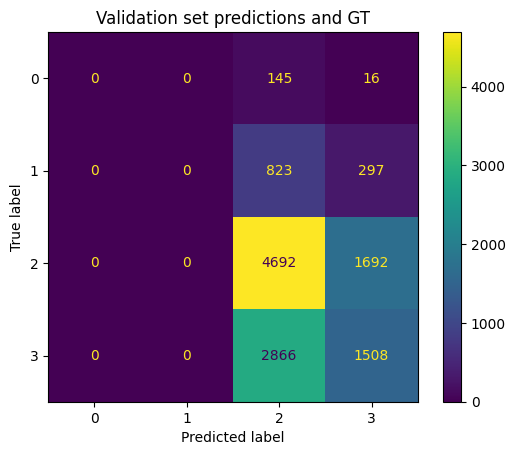

In [22]:
ConfusionMatrixDisplay.from_predictions(result_df['y_true'], result_df['y_pred'])
plt.title('Validation set predictions and GT')
plt.show()

## Male Predictions Confusion Matrix

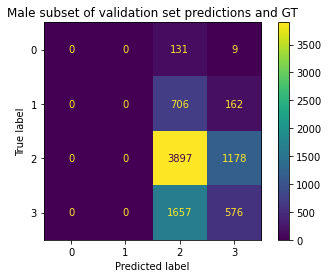

In [14]:
male_results = result_df[result_df['gender']==1]
ConfusionMatrixDisplay.from_predictions(male_results['y_true'], male_results['y_pred'])
plt.title('Male subset of validation set predictions and GT')
plt.show()

In [24]:
f1_score(
    male_results['y_true'],
    male_results['y_pred'],
    average=None
)

array([0.        , 0.        , 0.67974882, 0.27705628])

In [25]:
f1_score(
    male_results['y_true'],
    male_results['y_pred'],
    average='weighted'
)

0.4892246201770011

In [26]:
#precision_score, recall_score
precision_score(
    male_results['y_true'],
    male_results['y_pred'],
    average=None
)

C:\Users\netwo\anaconda3\envs\Thesis-minimum\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.        , 0.        , 0.60976373, 0.29922078])

In [27]:
recall_score(
    male_results['y_true'],
    male_results['y_pred'],
    average=None
)

array([0.        , 0.        , 0.76788177, 0.25794895])

# Female Prediction Confusion Matrix

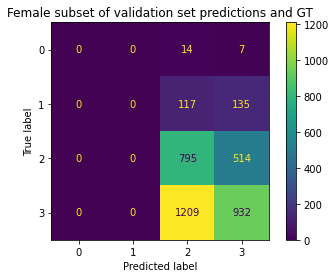

In [15]:
female_results = result_df[result_df['gender']==0]
ConfusionMatrixDisplay.from_predictions(female_results['y_true'], female_results['y_pred'])
plt.title('Female subset of validation set predictions and GT')
plt.show()

In [29]:
f1_score(
    female_results['y_true'],
    female_results['y_pred'],
    average=None
)

array([0.        , 0.        , 0.46167247, 0.49986592])

In [30]:
f1_score(
    female_results['y_true'],
    female_results['y_pred'],
    average='weighted'
)

0.44978302283374516

In [31]:
#precision_score, recall_score
precision_score(
    female_results['y_true'],
    female_results['y_pred'],
    average=None
)

C:\Users\netwo\anaconda3\envs\Thesis-minimum\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.        , 0.        , 0.37236534, 0.58690176])

In [32]:
recall_score(
    female_results['y_true'],
    female_results['y_pred'],
    average=None
)

array([0.        , 0.        , 0.60733384, 0.4353106 ])

# Classification report broken down by gender

In [16]:
report = classification_report(male_results['y_true'], male_results['y_pred'], labels=[0,1,2,3], zero_division=0) 
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       140
           1       0.00      0.00      0.00       868
           2       0.61      0.77      0.68      5075
           3       0.30      0.26      0.28      2233

    accuracy                           0.54      8316
   macro avg       0.23      0.26      0.24      8316
weighted avg       0.45      0.54      0.49      8316



In [17]:
report = classification_report(female_results['y_true'], female_results['y_pred'], labels=[0,1,2,3], zero_division=0) 
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.00      0.00      0.00       252
           2       0.37      0.61      0.46      1309
           3       0.59      0.44      0.50      2141

    accuracy                           0.46      3723
   macro avg       0.24      0.26      0.24      3723
weighted avg       0.47      0.46      0.45      3723



# Other Metrics
- These are not supported for multi-class problems

In [33]:
from fairlearn.metrics import demographic_parity_difference
demographic_parity_difference(
    y_true=result_df['y_true'],
    y_pred=result_df['y_pred'], 
    sensitive_features=result_df['gender']
)

0.0

In [34]:
from fairlearn.metrics import demographic_parity_ratio
demographic_parity_ratio(
    y_true=result_df['y_true'],
    y_pred=result_df['y_pred'], 
    sensitive_features=result_df['gender']
)

C:\Users\netwo\anaconda3\envs\Thesis-minimum\lib\site-packages\fairlearn\metrics\_metric_frame.py:515: RuntimeWarning: invalid value encountered in double_scalars
  result = self.group_min() / self.group_max()


nan

# References for multiclass metrics:

https://datascience.stackexchange.com/questions/81034/how-to-properly-compare-these-two-confusion-matrix

https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f

notes from https://towardsdatascience.com/the-f1-score-bec2bbc38aa6:
- A model will obtain a high F1 score if both Precision and Recall are high
- A model will obtain a low F1 score if both Precision and Recall are low
- A model will obtain a medium F1 score if one of Precision and Recall is low and the other is high

In [35]:
# F1 Scores

In [36]:
f1_score(
    result_df['y_true'],
    result_df['y_pred'],
    average=None
)

array([0.        , 0.        , 0.62937626, 0.38240142])

In [37]:
# notes from https://www.baeldung.com/cs/multi-class-f1-score

In [38]:
# The first method, micro calculates positive and negative values globally:
f1_score(
    result_df['y_true'],
    result_df['y_pred'],
    average='micro'
)

0.5149929396129247

In [39]:
# Another averaging method, macro, take the average of each class’s F-1 score:
f1_score(
    result_df['y_true'],
    result_df['y_pred'],
    average='macro'
)

0.25294441940089885

Note that the macro method treats all classes as equal, independent of the sample sizes.

As expected, the micro average is higher than the macro average since the F-1 score of the majority class (class a) is the highest.

The third parameter we’ll consider in this tutorial is weighted. The class F-1 scores are averaged by using the number of instances in a class as weights:


In [40]:
f1_score(
    result_df['y_true'],
    result_df['y_pred'],
    average='weighted'
)

0.47267728544763865

# Additional Metrics

In [41]:
#precision_score, recall_score

In [42]:
precision_score(
    result_df['y_true'],
    result_df['y_pred'],
    average=None
)

C:\Users\netwo\anaconda3\envs\Thesis-minimum\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.        , 0.        , 0.55031668, 0.42926274])

In [43]:
recall_score(
    result_df['y_true'],
    result_df['y_pred'],
    average=None
)

array([0.        , 0.        , 0.73496241, 0.34476452])

# Label Prediction Distribution

<AxesSubplot: >

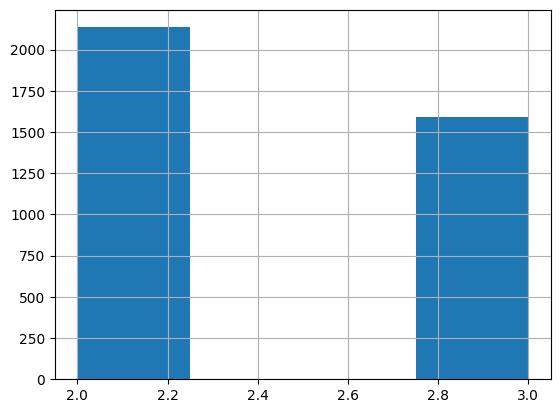

In [44]:
female_results['y_pred'].hist(bins=4)

<AxesSubplot: >

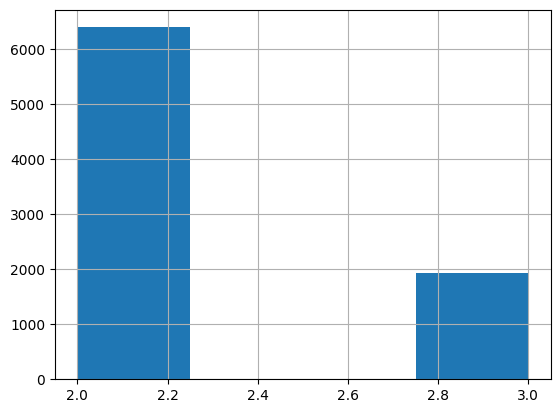

In [45]:
male_results['y_pred'].hist(bins=4)

<function matplotlib.pyplot.show(close=None, block=None)>

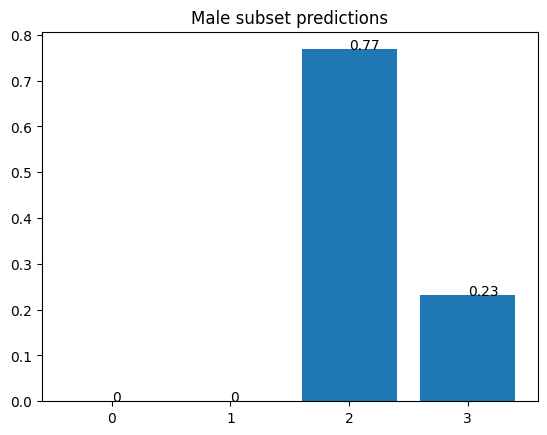

In [46]:
male_count_list = [0, 0, 0, 0]
for pred in male_results['y_pred'].value_counts().keys():
    male_count_list[pred] = male_results['y_pred'].value_counts()[pred] / sum(male_results['y_pred'].value_counts())
    
plt.title('Male subset predictions')
plt.bar([0,1,2,3], male_count_list, width=0.8, tick_label=[0,1,2,3])
for idx, value in enumerate(male_count_list):
    plt.text(idx, value, round(value, 2))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

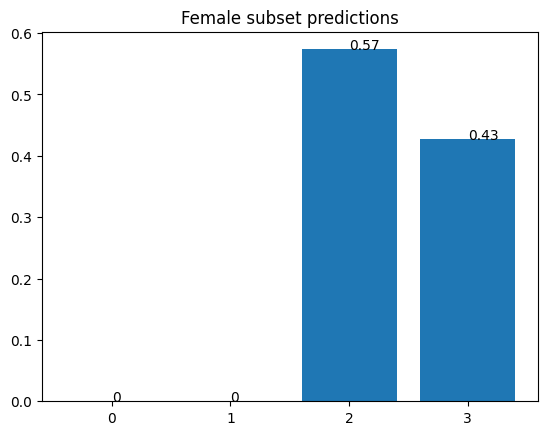

In [47]:
female_count_list = [0, 0, 0, 0]
for pred in female_results['y_pred'].value_counts().keys():
    female_count_list[pred] = female_results['y_pred'].value_counts()[pred] / sum(female_results['y_pred'].value_counts())
    
plt.title('Female subset predictions')
plt.bar([0,1,2,3], female_count_list, width=0.8, tick_label=[0,1,2,3])
for idx, value in enumerate(female_count_list):
    plt.text(idx, value, round(value, 2))
plt.show